<a href="https://colab.research.google.com/github/somiljain7/AI/blob/master/forecast_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

                 Open    High     Low   Close   Volume  Bitcoin   BTC  \
Date                                                                    
1/3/2016 0:58  436.75  437.50  435.20  437.40  218.731     90.0  65.0   
1/3/2016 1:56  437.07  437.07  434.20  436.34   78.762     92.0  74.0   
1/3/2016 2:59  436.46  436.98  434.25  436.05  104.564     90.0  76.0   
1/3/2016 3:58  435.53  436.44  429.00  434.22  409.744     92.0  84.0   
1/3/2016 4:58  434.22  435.71  431.30  434.41   89.213     90.0  80.0   

               Blockchain  Cryptocurrency  Iota  
Date                                             
1/3/2016 0:58        57.0            62.0  70.0  
1/3/2016 1:56        48.0            48.0  71.0  
1/3/2016 2:59        55.0            55.0  65.0  
1/3/2016 3:58        62.0            68.0  81.0  
1/3/2016 4:58        63.0            58.0  71.0  


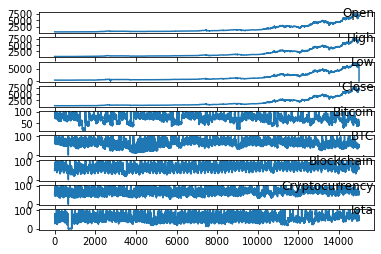

[[ 436.75  437.5   435.2  ...   57.     62.     70.  ]
 [ 437.07  437.07  434.2  ...   48.     48.     71.  ]
 [ 436.46  436.98  434.25 ...   55.     55.     65.  ]
 ...
 [6900.09 6973.   6885.84 ...   57.     57.     68.  ]
 [6971.42 7124.37 6961.61 ...   64.     63.     71.  ]
 [7110.   7250.     70.   ...     nan     nan     nan]]
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.005779   0.005406   0.057666   0.005872   0.015952   0.879518   
2   0.005823   0.005349   0.057533   0.005728   0.005730   0.903614   
3   0.005740   0.005337   0.057540   0.005688   0.007614   0.879518   
4   0.005613   0.005265   0.056842   0.005438   0.029901   0.903614   
5   0.005434   0.005168   0.057147   0.005464   0.006493   0.879518   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)   var1(t)   var2(t)   var3(t)  \
1       0.65       0.57       0.62        0.70  0.005823  0.005349  0.057533   
2       0.74       0.48       0.48        0.71  0.005740  0.005337  0.057540 

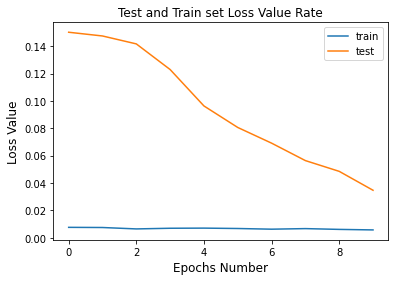

(10490, 19)
(4497, 19)
[ 907.75085  909.76245  911.7635  ... 1831.4258  1855.2028  1856.8173 ]
10490
Train RMSE: 1111.992
Test RMSE: 349.768


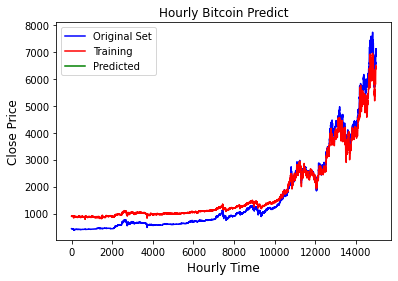

In [ ]:
import pandas as pd 
from pandas import DataFrame
from pandas import concat
from math import sqrt
from numpy import concatenate
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as pyplot 
import numpy as np 
from sklearn.preprocessing import MinMaxScaler
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation
from pandas import read_csv

# Load dataset by using Pandas library 
dataset = read_csv('Bitcoin3D.csv', header=0, index_col=0)
print(dataset.head())
values = dataset.values

# Here was prepared column for visualizing
groups = [0, 1, 2, 3, 5, 6,7,8,9]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# Here is created input columns which are (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# Here is created output/forecast column which are (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# here checked values numeric format 
values = values.astype('float32')
print(values)

# Dataset values are normalized by using MinMax method
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
#print(scaled)

# Normalized values are converted for supervised learning 
reframed = series_to_supervised(scaled,1,1)
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

# Dataset is splitted into two groups which are train and test sets
values = reframed.values 
train_size = int(len(values)*0.70)
train = values[:train_size,:]
test = values[train_size:,:]

# Splitted datasets are splitted to trainX, trainY, testX and testY 
trainX, trainY = train[:,:-1], train[:,13]
testX, testY = test[:,:-1], test[:,13]
print(trainY, trainY.shape)

# Train and Test datasets are reshaped in 3D size to be used in LSTM
trainX = trainX.reshape((trainX.shape[0],1,trainX.shape[1]))
testX = testX.reshape((testX.shape[0],1,testX.shape[1]))
print(trainX.shape, trainY.shape,testX.shape,testY.shape)

# LSTM model is created and adjusted neuron structure
model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.05))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(loss='mae', optimizer='adam')
# Dataset is trained by using trainX and trainY
history = model.fit(trainX, trainY, epochs=10, batch_size=25, validation_data=(testX, testY), verbose=2, shuffle=False)

# Loss values are calculated for every training epoch and are visualized
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.title("Test and Train set Loss Value Rate")
pyplot.xlabel('Epochs Number', fontsize=12)
pyplot.ylabel('Loss Value', fontsize=12)
pyplot.legend()
pyplot.show()

# Prediction process is performed for train dataset
trainPredict = model.predict(trainX)
trainX = trainX.reshape((trainX.shape[0], trainX.shape[2]))
print(trainX.shape)

# Prediction process is performed for test dataset
testPredict = model.predict(testX)
testX = testX.reshape((testX.shape[0], testX.shape[2]))
print(testX.shape)

# Trains dataset inverts scaling for training
trainPredict = concatenate((trainPredict, trainX[:, -9:]), axis=1)
trainPredict = scaler.inverse_transform(trainPredict)
trainPredict = trainPredict[:,0]
print(trainPredict)
print(len(trainPredict))

# Test dataset inverts scaling for forecasting
testPredict = concatenate((testPredict, testX[:, -9:]), axis=1)
testPredict = scaler.inverse_transform(testPredict)
testPredict = testPredict[:,0]

# invert scaling for actual
testY = testY.reshape((len(testY), 1))
inv_y = concatenate((testY, testX[:, -9:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
#print('actual: ', len(inv_y))

# Performance measure calculated by using mean_squared_error for train and test prediction
rmse2 = sqrt(mean_squared_error(trainY, trainPredict))
print('Train RMSE: %.3f' % rmse2)
rmse = sqrt(mean_squared_error(inv_y, testPredict))
print('Test RMSE: %.3f' % rmse)

#print(testPredict)
#print(type(trainPredict))

# train and test prediction are concatenated
final = np.append(trainPredict, testPredict)
#print(len(son))

final = pd.DataFrame(data=final, columns=['Close'])
actual = dataset.Close
actual = actual.values
actual = pd.DataFrame(data=actual, columns=['Close'])

# Finally training and prediction result are visualized
pyplot.plot(actual.Close, 'b', label='Original Set')
pyplot.plot(final.Close[0:16781], 'r' , label='Training')
pyplot.plot(final.Close[16781:len(final)], 'g' , label='Predicted')
pyplot.title("Hourly Bitcoin Predict")
pyplot.xlabel('Hourly Time', fontsize=12)
pyplot.ylabel('Close Price', fontsize=12)
pyplot.legend(loc='best')
pyplot.show()
